In [1]:
# # 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('F:/hk2 nam3/nhi/is403/IS403_O21_04/Dataset/NVL Historical Data 2018.csv')
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df = df[::-1]
df1=df.reset_index()['Price']
df1

0       27815.0
1       28410.0
2       28707.0
3       28962.0
4       29556.0
         ...   
1547    16700.0
1548    16500.0
1549    16550.0
1550    17100.0
1551    17100.0
Name: Price, Length: 1552, dtype: float64

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
test_size

310

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)



In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
X_train.shape

(1140, 100, 1)

In [11]:
from keras.layers import LSTM, Dense, Activation

def swish(x):
    return x * tf.keras.backend.sigmoid(x)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



In [12]:
# 9. Fit mô hình với dữ liệu train
# model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for improvement
    patience=3,         # Stop training after 3 epochs of no improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

model.fit(X_train, y_train,
          validation_data=(X_test, ytest),
          epochs=100,
          batch_size=64,
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - loss: 0.1054 - val_loss: 0.0054
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0087 - val_loss: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0041 - val_loss: 5.7217e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0041 - val_loss: 6.7923e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0037 - val_loss: 4.8135e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0032 - val_loss: 4.8576e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0028 - val_loss: 5.2143e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0020 - val_loss: 3.6068e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0015 - val_loss: 3.5222e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0023 - val_loss: 2.8795e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0019 - val_loss: 2.2336e-04
Epoch 

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
y_pred.shape

(210, 1)

In [16]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
test_mae = np.mean(np.abs(ytest - y_pred))


print('Testing RMSE:', test_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

Testing RMSE: 16433.73149578473
Testing RMSE: 16433.73149578473
Testing MAE: 16306.134606270136


In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=250
i=0
while(i<30):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.02009353 0.02983584 0.02861805 0.02800916 0.03105363 0.02983584
 0.03166253 0.03044474 0.03166253 0.03653368 0.03836037 0.03714258
 0.04810268 0.05845389 0.05175605 0.04810268 0.05540942 0.05601832
 0.05236495 0.05053826 0.04079595 0.046276   0.04262263 0.04505821
 0.04688489 0.04932047 0.04018705 0.04018705 0.03288032 0.03348921
 0.03714258 0.04323153 0.04201374 0.03957816 0.04140484 0.03714258
 0.03714258 0.03592479 0.03775147 0.03592479 0.03653368 0.03592479
 0.03288032 0.03409811 0.03775147 0.03957816 0.04444932 0.04384042
 0.03957816 0.04079595 0.05236495 0.04810268 0.05297384 0.05297384
 0.06515174 0.06028058 0.06088947 0.05662721 0.04566711 0.05175605
 0.05175605 0.05358274 0.05175605 0.05662721 0.057845   0.06515174
 0.057845   0.05601832 0.05236495 0.05601832 0.05419163 0.05053826
 0.05175605 0.05662721 0.05419163 0.05297384 0.05723611 0.05967168
 0.06210726 0.05845389 0.05419163 0.05540942 0.05967168 0.07245847
 0.07245847 0.08463637 0.092552   0.09864095 0.104

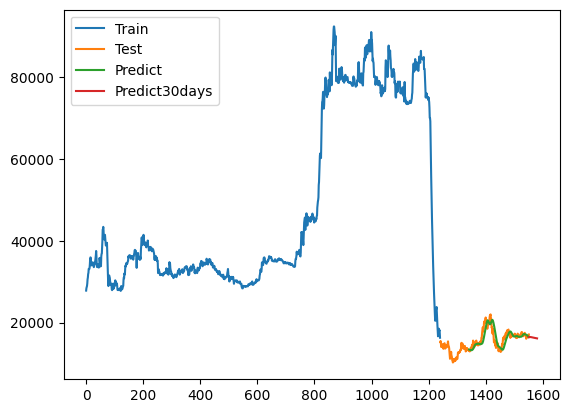

In [18]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size+1, step=1)

plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()